<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/MachineLearning/How_to_predict_cancer_survival_with_BigQueryML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Predict Cancer Survival Time with BigQuery ML

Check out other notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

- **Title:** How to predict cancer survival time with BigQuery ML
- **Author:** John Phan
- **Created:** 2022-01-22
- **Purpose:** Demonstrate use of linear regression in BigQuery ML to predict cancer patient survival time 
- **URL:** https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_predict_cancer_survival_time_with_BigQuery_ML.ipynb

This notebook demonstrates how to predict the survival time in months for cancer patients using BigQuery ML's linear regression function. It uses a kidney cancer study that identified a 15 gene predictive signature. The study is available here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6113007/ 

The total BigQuery cost for running this notebook is <$0.15. 

## Import Dependencies

In [ ]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth

# Data Analytics
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

## Authenticate

Before using BigQuery, we need to get authorization for access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html). Alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

In [ ]:
# if you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()

# alternatively, use the gcloud SDK
#!gcloud auth application-default login

## Parameters

Customize the following parameters based on your notebook, execution environment, or project. BigQuery ML must create and store classification models, so be sure that you have write access to the locations stored in the "bq_dataset" and "bq_project" variables.

In [ ]:
# set the google project that will be billed for this notebook's computations
google_project = 'google-project' ## CHANGE ME

# bq project for storing ML model
bq_project = 'bq-project' ## CHANGE ME

# bq dataset for storing ML model
bq_dataset = 'scratch' ## CHANGE ME

# name of temporary table for data
bq_tmp_table = 'tmp_kirc_data'

# name of ML model
bq_ml_model = 'tcga_kirc_ml_reg_model'

# in this example, we'll be using the Ovarian cancer TCGA dataset
cancer_type = 'TCGA-KIRC'

# 14 genes used for prediction model, taken from Li et al.
# Note: one gene (ZIC2) was omitted from the original set of 15 genes due to 
# missing values in some TCGA samples. 
genes = [
  'CCDC137', 'KL', 'FBXO3', 'CDC7', 'IL20RB', 'CDCA3', 'ANAPC5',
  'OTOF', 'POFUT2', 'ATP13A1', 'MC1R', 'BRD9', 'ARFGAP1', 'COL7A1'
]

# clinical data table
clinical_table = 'isb-cgc-bq.TCGA_versioned.clinical_gdc_r29'

# RNA seq data table
rnaseq_table = 'isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r28'


## BigQuery Client

Create the BigQuery client.

In [ ]:
# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

## Create a Table with a Subset of the Gene Expression Data

Pull RNA-seq gene expression data from the TCGA RNA-seq BigQuery table, join it with clinical labels, and pivot the table so that it can be used with BigQuery ML. In this example, we will label each sample with the patient's survival time. This prepares the data for linear regression. 

Prediction modeling with RNA-seq data typically requires a feature selection step to reduce the dimensionality of the data before training a regression model. However, to simplify this example, we will use a pre-identified set of 14 genes from the study by Li et al. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6113007/). Note that one gene was omitted due to missing values.

Creation of a BQ table with only the data of interest reduces the size of the data passed to BQ ML and can significantly reduce the cost of running BQ ML queries. This query also randomly splits the dataset into "training" and "testing" sets with roughly equal sample sizes using the "FARM_FINGERPRINT" hash function in BigQuery. "FARM_FINGERPRINT" generates an integer from the input string. More information can be found [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/hash_functions).

In [ ]:
# construct and display the query
tmp_table_query = ("""
  BEGIN
  CREATE OR REPLACE TABLE `{bq_project}.{bq_dataset}.{bq_tmp_table}` AS

    SELECT * FROM (
      SELECT
        labels.submitter_id AS sample,
        labels.data_partition AS data_partition,
        MAX(labels.survival) AS survival,
        ge.gene_name AS gene_name,
        -- Multiple samples may exist per case, take the max value
        MAX(LOG(ge.HTSeq__FPKM_UQ+1)) AS gene_expression
      FROM `{rnaseq_table}` AS ge
      INNER JOIN (
        SELECT
          *
        FROM (
          SELECT
            submitter_id,
            demo__days_to_death AS survival,
            CASE 
              WHEN MOD(ABS(FARM_FINGERPRINT(case_id)), 10) < 5 THEN 'training'
              WHEN MOD(ABS(FARM_FINGERPRINT(case_id)), 10) >= 5 THEN 'testing'
            END AS data_partition
            FROM `{clinical_table}`
            WHERE
              proj__project_id = '{cancer_type}'
              AND demo__days_to_death IS NOT NULL
            ORDER BY demo__days_to_death DESC
        )
      ) labels
      ON labels.submitter_id = ge.case_barcode
      WHERE gene_name IN ({genes})
      GROUP BY sample, data_partition, gene_name
    )
    PIVOT (
      MAX(gene_expression) FOR gene_name IN ({genes})
    );
  END;
""").format(
  bq_project=bq_project,
  bq_dataset=bq_dataset,
  bq_tmp_table=bq_tmp_table,
  rnaseq_table=rnaseq_table,
  clinical_table=clinical_table,
  cancer_type=cancer_type,
  genes=''.join(["'","','".join(genes),"'"])
)

print(tmp_table_query)

In [ ]:
# this query processes 20 GB and costs approximately $0.10
tmp_table_result = client.query(tmp_table_query)

Let's take a look at this subset table. The data has been pivoted such that each of the 14 genes is available as a column that can be "SELECTED" in a query. In addition, the "survival" and "data_partition" columns simplify data handling for model training and evaluation.

In [ ]:
# construct and display the query
tmp_table_query = ("""
  SELECT
    * --usually not recommended to use *, but in this case, we want to see all 14 genes
  FROM `{bq_project}.{bq_dataset}.{bq_tmp_table}`
""").format(
    bq_project=bq_project,
    bq_dataset=bq_dataset,
    bq_tmp_table=bq_tmp_table
)

print(tmp_table_query)

In [ ]:
# this query processes 24 KB of data and costs approximately <$.01
tmp_table_data = client.query(tmp_table_query).result().to_dataframe()

print(tmp_table_data.info())
tmp_table_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sample          171 non-null    object 
 1   data_partition  171 non-null    object 
 2   survival        171 non-null    int64  
 3   CCDC137         171 non-null    float64
 4   KL              171 non-null    float64
 5   FBXO3           171 non-null    float64
 6   CDC7            171 non-null    float64
 7   IL20RB          171 non-null    float64
 8   CDCA3           171 non-null    float64
 9   ANAPC5          171 non-null    float64
 10  OTOF            171 non-null    float64
 11  POFUT2          171 non-null    float64
 12  ATP13A1         171 non-null    float64
 13  MC1R            171 non-null    float64
 14  BRD9            171 non-null    float64
 15  ARFGAP1         171 non-null    float64
 16  COL7A1          171 non-null    float64
dtypes: float64(14), int64(1), object(2)

,sample,data_partition,survival,CCDC137,KL,FBXO3,CDC7,IL20RB,CDCA3,ANAPC5,OTOF,POFUT2,ATP13A1,MC1R,BRD9,ARFGAP1,COL7A1
0,TCGA-CJ-6028,testing,1625,11.216338,12.676609,11.529611,10.552132,13.420337,9.576919,12.150855,7.925582,11.132402,11.657865,8.470426,11.199126,11.771935,7.313227
1,TCGA-CZ-4854,testing,1404,11.731425,12.212952,11.528917,10.181957,13.941180,9.996899,12.648024,6.697751,12.210341,12.480140,10.281334,11.856343,13.170371,8.943372
2,TCGA-B2-4098,testing,51,11.769022,12.666833,11.839622,10.033014,8.719929,9.632780,12.279318,8.088610,12.112633,12.407358,10.066374,11.396366,12.585813,9.926065
3,TCGA-A3-3311,testing,1191,11.830858,12.955815,11.763534,10.608835,12.370209,9.571285,12.170460,6.699314,11.749964,12.099278,9.164627,11.192177,12.183060,7.403868
4,TCGA-B0-4852,testing,1121,11.574152,13.141051,12.073442,10.857984,10.512210,9.591187,12.323289,6.498190,11.874025,11.547748,9.965271,11.450055,11.997954,8.424718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,TCGA-B0-4813,training,18,12.333895,9.163342,11.799495,11.554844,10.220908,10.797781,12.734280,7.347187,12.049739,12.349788,11.408412,11.444654,12.891557,10.070090
167,TCGA-CZ-4864,training,1315,11.699855,15.026180,12.028713,10.553001,8.751080,9.256490,12.202233,6.383244,12.015569,12.155789,10.667438,11.297545,12.360134,9.111837
168,TCGA-B0-4828,training,307,12.238516,12.375879,11.869018,10.214629,10.340151,10.355349,12.447745,7.279171,12.205795,12.283201,10.389967,11.724181,12.750724,9.640540
169,TCGA-BP-4352,training,344,12.004617,11.087133,11.029591,11.212132,15.324223,11.543118,12.738892,6.282777,13.525317,13.167573,11.451097,12.280621,14.455638,12.491338


# Train the Machine Learning Model

Now we can train a linear model using BigQuery ML with the data stored in the subset table. This model will be stored in the location specified by the "bq_ml_model" variable, and can be reused to predict samples in the future.

We pass two options to the BQ ML model: model_type and input_label_cols. Model_type specifies the machine learning model type. In this case, we use "LINEAR_REG" to train a linear regression model. Other model options are documented [here](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create). Input_label_cols tells BigQuery that the "survival" column should be used to determine each sample's prediction target. 

**Warning**: BigQuery ML models can be very time-consuming and expensive to train. Please check your data size before running BigQuery ML commands. Information about BigQuery ML costs can be found [here](https://cloud.google.com/bigquery-ml/pricing).

In [ ]:
# construct and display the query
ml_model_query = ("""
  CREATE OR REPLACE MODEL `{bq_project}.{bq_dataset}.{bq_ml_model}`
  OPTIONS
    (
      model_type='LINEAR_REG',
      input_label_cols=['survival']
    ) AS
  SELECT * EXCEPT(sample, data_partition)  -- when training, we only the labels and feature columns
  FROM `{bq_project}.{bq_dataset}.{bq_tmp_table}`
  WHERE data_partition = 'training' -- using training data only
""").format(
  bq_project=bq_project,
  bq_dataset=bq_dataset,
  bq_ml_model=bq_ml_model,
  bq_tmp_table=bq_tmp_table
)

print(ml_model_query)

In [ ]:
# create ML model using BigQuery
# this query processes 21.6 KB of data and costs approximately <$0.01
ml_model_result = client.query(ml_model_query).result()
print(ml_model_result)

# now get the model metadata
ml_model = client.get_model('{}.{}.{}'.format(bq_project, bq_dataset, bq_ml_model))
print(ml_model)

# Evaluate the Machine Learning Model
Once the model has been trained and stored, we can evaluate the model's performance using the "testing" dataset from our subset table. Evaluating a BQ ML model is generally less expensive than training. 

Use the following query to evaluate the BQ ML model. Note that we're using the "data_partition = 'testing'" clause to ensure that we're only evaluating the model with test samples from the subset table.  

BigQuery's ML.EVALUATE function returns several performance metrics: mean absolute error, mean squared error, mean squared log error, median absolute error, r-squared score, and explained variance. 

In [ ]:
# construct and display the query
ml_eval_query = ("""
SELECT * FROM ML.EVALUATE (MODEL `{bq_project}.{bq_dataset}.{bq_ml_model}`, 
  (
    SELECT * EXCEPT(sample, data_partition)
    FROM `{bq_project}.{bq_dataset}.{bq_tmp_table}`
    WHERE data_partition = 'testing'
  )
)
""").format(
  bq_project=bq_project,
  bq_dataset=bq_dataset,
  bq_ml_model=bq_ml_model,
  bq_tmp_table=bq_tmp_table
)

print(ml_eval_query)

In [ ]:
# this query processes 21.7 KB and costs approximately <$0.01
ml_eval = client.query(ml_eval_query).result().to_dataframe()

In [ ]:
# Display the table of evaluation results
ml_eval

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,626.02056,600243.377303,1.437898,582.148007,-0.050824,-0.005055


The evaluation metrics indicate that the model does not fit the data very well. We can visualize the model to verify. In order to do this, we extract the predicted survival times for each training sample.

In [ ]:
# construct and display the query
ml_train_predict_query = ("""
SELECT
  predicted_survival,
  survival
FROM ML.PREDICT (MODEL `{bq_project}.{bq_dataset}.{bq_ml_model}`, 
  (
    SELECT * EXCEPT(sample, data_partition)
    FROM `{bq_project}.{bq_dataset}.{bq_tmp_table}`
    WHERE data_partition = 'training' -- Use the training dataset
  )
)
""").format(
  bq_project=bq_project,
  bq_dataset=bq_dataset,
  bq_ml_model=bq_ml_model,
  bq_tmp_table=bq_tmp_table
)

print(ml_train_predict_query)

In [ ]:
# this query processes 21.7 KB and costs approximately <$0.01
ml_train_predict = client.query(ml_train_predict_query).result().to_dataframe()

In [ ]:
# display the table comparing predicted survival times to actual survival times
ml_train_predict

,predicted_survival,survival
0,791.428634,561
1,869.231141,885
2,1075.405569,1097
3,883.098339,1170
4,712.610919,446
...,...,...
79,914.315474,18
80,730.548522,1315
81,870.555353,307
82,455.844444,344


# Predict Outcome for One or More Samples
ML.EVALUATE evaluates a model's performance, but does not produce actual predictions for each sample. In order to do that, we need to use the ML.PREDICT function. The syntax is similar to that of the ML.EVALUATE function and returns "predicted_survival" and "survival".  

Note that the input dataset can include one or more samples, and must include the same set of features as the training dataset. 

In [ ]:
# construct and display the query
ml_test_predict_query = ("""
SELECT
  predicted_survival,
  survival
FROM ML.PREDICT (MODEL `{bq_project}.{bq_dataset}.{bq_ml_model}`, 
  (
    SELECT * EXCEPT(sample, data_partition)
    FROM `{bq_project}.{bq_dataset}.{bq_tmp_table}`
    WHERE data_partition = 'testing' -- Use the testing dataset
  )
)
""").format(
  bq_project=bq_project,
  bq_dataset=bq_dataset,
  bq_ml_model=bq_ml_model,
  bq_tmp_table=bq_tmp_table
)

print(ml_test_predict_query)

In [ ]:
# this query processes 21.7 KB and costs approximately <$0.01
ml_test_predict = client.query(ml_test_predict_query).result().to_dataframe()

In [ ]:
# Display the table of prediction results
ml_test_predict

,predicted_survival,survival
0,872.025666,1625
1,932.573507,1404
2,723.386120,51
3,1026.206731,1191
4,871.634196,1121
...,...,...
82,977.088050,1371
83,1205.094888,1003
84,1052.289620,311
85,696.153764,1493


## Visualize the Linear Regression Model

Now we can visualize the linear regression model overlayed on the training and testing sets. 

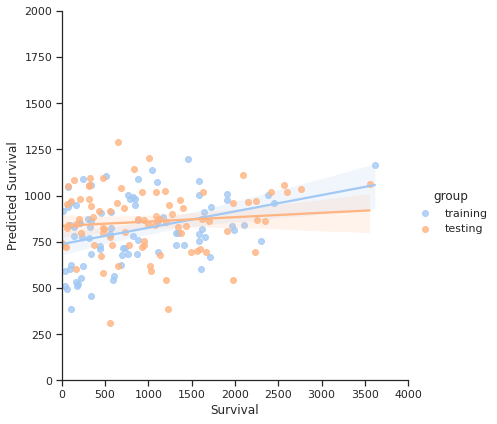

In [ ]:
# combine training and testing results into single data frame
ml_train_predict['group'] = 'training'
ml_test_predict['group'] = 'testing'
combined = pd.concat([ml_train_predict, ml_test_predict])

# use seaborn to generate a scatter plot of linear regression results
sns.set_theme(style='ticks', palette='pastel')
ax = sns.lmplot(data=combined, hue='group', x='survival', y='predicted_survival', height=6, aspect=1)
ax.set(xlim=(0,4000), ylim=(0,2000),xlabel='Survival',ylabel='Predicted Survival')

# Conclusion

Although there is a small positive correlation between predicted survival time and actual survival time, the relationship is weak (this is also reflected in the very small R-squared metric for the testing set). The variance of the predicted survival is large, but decreases as actual survival time increases. Note that even for the training samples (orange points) the model does not predict survival well, suggesting that it is underfitting. 

This example used a pre-selected set of 14 genes from a previous study. However, performing additional feature selection or increasing the feature size (e.g., increase to 30+ features) may improve model performance.